# Intro

In this example from _Hands-On Machine Learning with Scikit-learn, Keras & TensorFlow_ by Aurelien Geron, we will use the California Housing Prices dataset from StatLib. <br>
This dataset is based on data from the 1990 California census.

The data we will use includes metrics such as population, median income, median housing price etc. We will try to predict the median housing price for each block group / district in California. 

### 1. First, let's decide what kind of task we have on our hands

This is a typical supervised learning task, as we will use labeled examples (each instance comes with an expected output - the median house pricing). It is also a typical regression task since we want to predict a value. More specifically, this is a _multiple regression_ problem, since we will use several features to make a prediction. It is also a _univariate regression_ problem, as we want to predict a single value for each entry.

If we think about it in more mathematical terms, then we can associate our model with the following function:
$$
f : A \rightarrow B
$$
where $A$ is the set that contains features and $B$ is a set that contains targets.<br>
So, in our case, $f$ takes several variables and outputs a single one:
$$
f(x_1, x_2, ...) = y
$$
This is why we have a _multiple univariate_ regression task.<br>
If $dim(A) = 1$ then the problem would have been a _simple_ regression one. If $dim(B) > 1$ then it would have been a _multivariate_ regression task.

### 2. Now, let's select a performance measure

In regression problems we usually use the _root mean square error_ (RMSE). It gives us an idea of how much error the system typically makes in its predictions.

$$
RMSE(X, h) = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(h(x^{(i)}) - y^{(i)})^2}
$$

- $m$ - the number of instances/entries in the dataset

- $x^{(i)}$ - the vector of all feature values (excluding the label or target) of the $i^{th}$ instance in the dataset

- $y^{i}$ - the label corresponding to the $i^{th}$ vector of features

- $X$ - the matrix containing all the feature values of all the entries in the dataset. It has the following structure:
$$
X = 
\begin{pmatrix}
(x^{(1)})^T \\
(x^{(2)})^T \\
... \\ \\
(x^{(m)})^T
\end{pmatrix}
$$

- $h$ - the system's prediction fucntion, also called a _hypothesis_ (or estimator). When the system receives an instance's feature vector $x^{(i)}$, it outputs a predicted value $\hat{y}^{(i)} = h(x^{(i)})$

- $RMSE(x, h)$ - the **cost** function measured on the set of examples using the hypothesis $h$

### 3. Coding time!

First of all, let's load the data we'll work with:

In [21]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [22]:
def load_housing_data():
    tar_path = Path("datasets/housing.tgz")
    if not tar_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tar_path)
        with tarfile.open(tar_path) as housing_tar:
            housing_tar.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [23]:
housing = load_housing_data()

^ when `load_housing_data()` is called, it looks for _datasets/housing.tgz_. If it does not find it, it creates the _datasets_ directory, downloads _housing.tgz_ and extracts its content in the _datasets_ directory. Then we use pandas to read from the .csv file inside it.

In [24]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [25]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


^ There are 20,640 entries in the dataset (so it's a fairly small one by ML standards). <br>
An important thing to notice is that the `total_bedrooms` attribute has only 20,433 non-null values, meaning that there are districts missing this feature. We will take care of this a bit later.

In [26]:
housing.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [27]:
import matplotlib.pyplot as plt

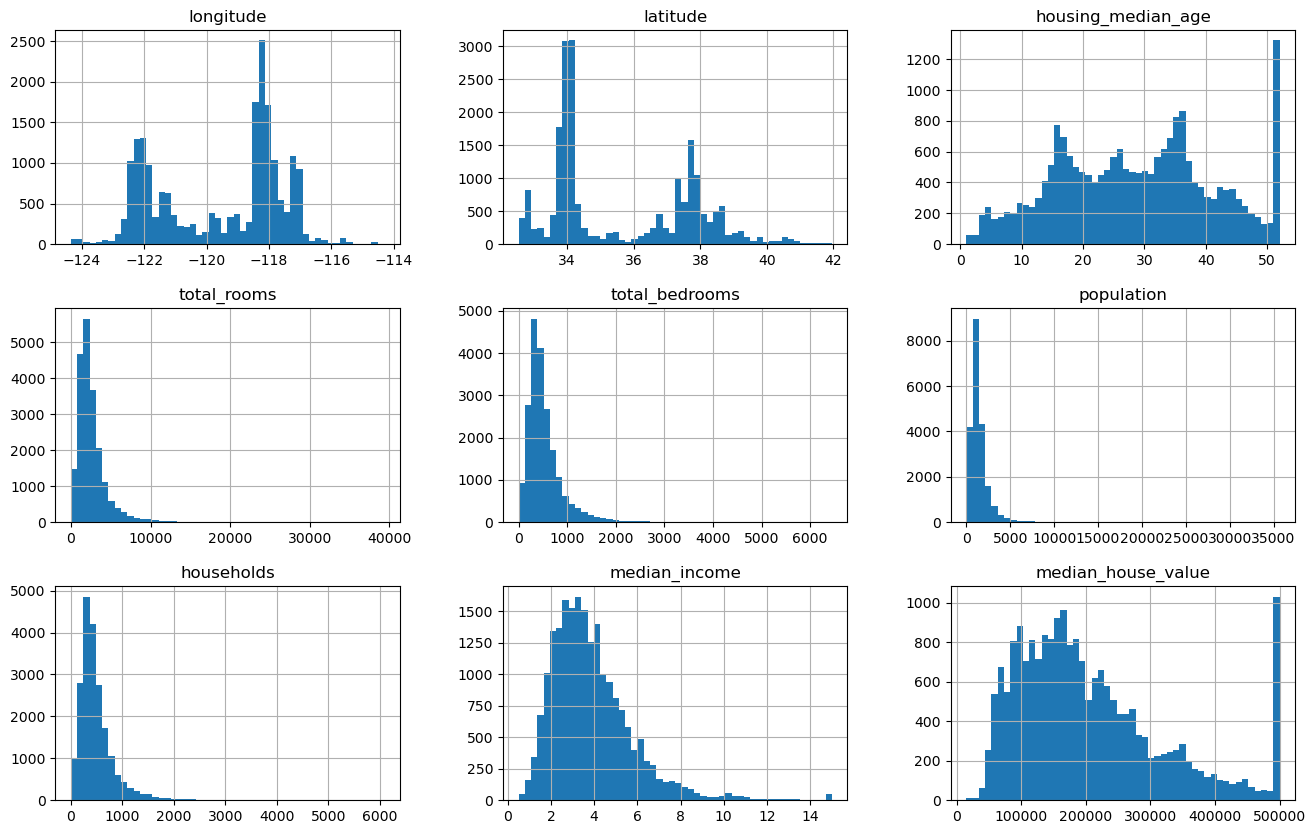

In [28]:
housing.hist(bins=50, figsize=(16, 10))
plt.show()

Looking at the plotted histograms, we can notice a few things:
- the `median_income` attribute is not expressed in USD, but in tens of thousands of dollars (so 3 means $30,000). 

- the `median_income` is capped at 0.5 and 15.

- `housing_median_age` and `median_house_value` are also capped. This can be a serious problem because `median_house_value` is our target attribute. our ML model may learn that house prices never go beyound the cap value. We will need to either ask for proper label/target collection without the value cap or remove those districts from the training and test sets. 

- all these attributes have very different scales.

- many histograms are _skewed right_: they extend much farther to the right of the median that to the left. This may make it harder for ML algorithms to detect patterns. 

We will tackle these issues a bit later.

Now we need to create a test set. That may seem simple - just pick some random entries, 20% of the dataset, and set them aside:

In [29]:
import numpy as np

In [30]:
def shuffle_and_split(data, ratio):
    shuffled_indxs = np.random.permutation(len(data))
    testset_size = int(len(data) * ratio)
    test_indxs = shuffled_indxs[:testset_size]
    train_indxs = shuffled_indxs[testset_size:]
    return data.iloc[train_indxs], data.iloc[test_indxs]

In [31]:
# We can now use the function like this:
trainset, testset = shuffle_and_split(housing, 0.2)

^ This works, but there is a problem: if you re-run the code, it will generate a different test set. Over time, our ML algorithm will get to see the whole dataset, whish is something we want to avoid.

One possible solution is to save the test set on the first run by setting the random number generator's seed.

However, both these solutions will break the next time we fetch an updated dataset. A better option would be to use each instance's identifier to decide whether or not it goes in the test set. 

For example, we could compute a hash of each instance's identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even with a refreshed dataset:

In [32]:
from zlib import crc32

def is_in_testset(id, ratio):
    return crc32(np.int64(id)) < ratio * 2**32

def split_data_with_hash(data, ratio, idcol):
    ids = data[idcol]
    in_testset = ids.apply(lambda id_: is_in_testset(id_, ratio))
    return data.loc[~in_testset], data.loc[in_testset]

# unfortunately for us, this dataset does not have an ID column. The simples solution is to just use the row index as the ID.

housing_wid = housing.reset_index()
trainset, testset = split_data_with_hash(housing_wid, 0.2, "index")

^ if we're going to use the row index as a unique ID, we need to make sure that new data always gets appended to the end of the dataset. This is not always possible, so we can insteead use the most stable features to build a unique identifier.

For example, a district's latitude and longitude are guaranteed to stay the same (at least for the next few million years), so we will combine them to form an ID:

In [33]:
housing_wid["id"] = housing["longitude"] * 1000 + housing["latitude"]
trainset, testset = split_data_with_hash(housing_wid, 0.2, "id")

Alternatively, we could also use **Scikit-Learn**:

In [34]:
from sklearn.model_selection import train_test_split

trainset, testset = train_test_split(housing, test_size=0.2, random_state=42)

So far we have considered using purely _random sampling_ methods. This is fine if the dataset os very large, but it can sometimes introduce a _sampling bias_. 

A better way is to use _stratified sampling_: the dataset is divided into homogenous subgroups called _strata_. The right number of entries is sampled from each stratum in order to guarantee that the test set is representative of the data.

Suppose some experts told us that the median income is a very important attribute for predicting median housing prices. We thus want to ensure that the test set is representative of the various categories of income in the whole dataset.

Since the median income is a continuous numerical attribute, we need to create an income category feature.

After looking at the `median_income` histogram we can see that most values are clustered around 1.5 to 6 ($15,000 - $60,000), but some values go far beyond 6. It is important to have a sufficient number of entries from each stratum, or else the estimate of a stratum's importance may be biased. 

In [35]:
housing["income_ctg"] = pd.cut(housing["median_income"], bins=[0.0, 1.5, 4.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])

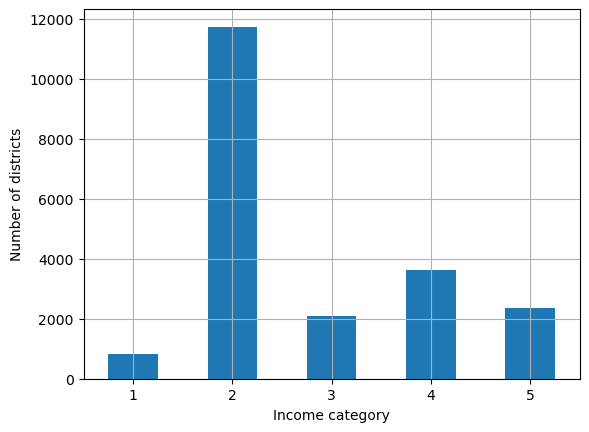

In [36]:
housing["income_ctg"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [37]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_ctg"]):
    strat_trainset_n = housing.iloc[train_index]
    strat_testset_n = housing.iloc[test_index]
    strat_splits.append([strat_trainset_n, strat_testset_n])

strat_trainset, strat_testset = strat_splits[0]

# alternatively, we can just use sklearn for stratified sampling:

strat_trainset, strat_testset = train_test_split(housing, test_size=0.2, stratify=housing["income_ctg"], random_state=42)

In [38]:
print(strat_testset["income_ctg"].value_counts() / len(strat_testset))
print(housing["income_ctg"].value_counts() / len(housing))

income_ctg
2    0.568314
4    0.176357
5    0.114341
3    0.101017
1    0.039971
Name: count, dtype: float64
income_ctg
2    0.568362
4    0.176308
5    0.114438
3    0.101066
1    0.039826
Name: count, dtype: float64


^ as you can see the stratified sample has almost identical proportions to the original dataset.

We won't be using the `income_ctg` column again so we'll just drop it now, reverting the data to its original state:

In [39]:
for set_ in (strat_trainset, strat_testset):
    set_.drop("income_ctg", axis=1, inplace=True)

### Visualizing the data
We will put aside the test set and only look at the training set (in order to avoid a _[snooping bias](https://www.wallstreetmojo.com/data-snooping-bias/)_)

If the dataset we're working with is extremely large (not our case right now) we can set aside an _exploration set_ for faster and simpler analysis. 

In [40]:
housing = strat_trainset.copy() # copy the original training set so we can have access to it later

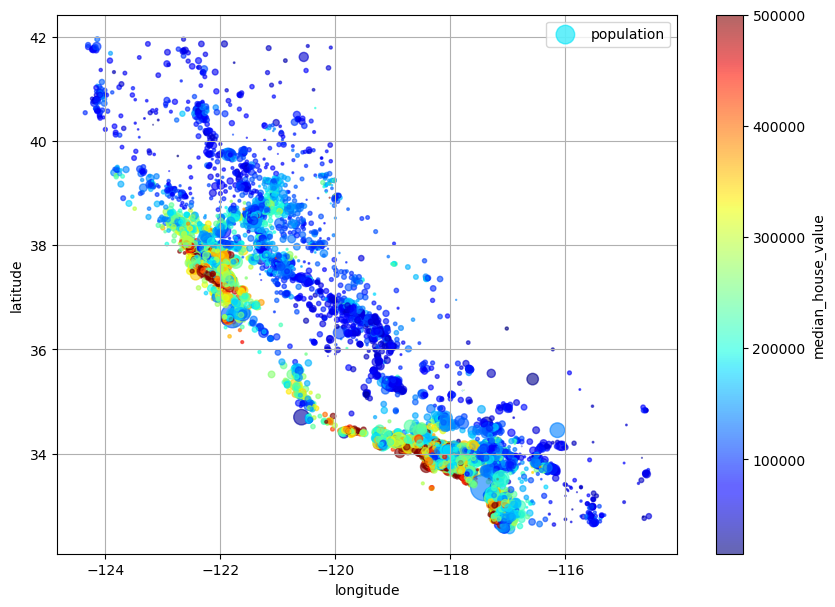

In [49]:
housing.plot(
    kind = "scatter",
    x = "longitude",
    y = "latitude",
    grid = True,
    alpha = 0.6, # makes it easier to properly see where there is a higher density of data points
    s = housing["population"] / 100, # radius of each circle represents population
    label = "population",
    c = "median_house_value", # color represents the price
    cmap = "jet", # blue - low values, red - high values (colormap settings)
    colorbar = True,
    legend = True,
    figsize = (10, 7)
)

plt.show()

If you look up California's population density, you can see that the plotted data makes sense. You can clearly see the Bay Area, Los Angeles, San Diego, as well as Sacramento and Fresno:
<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Population_density_of_California_counties_%282020%29.jpg/800px-Population_density_of_California_counties_%282020%29.jpg" width="500px">
    <figcaption>Source: Wikipedia</figcaption>
</figure>


Since the dataset is not that large, we can easily compute the [Standard Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) (also called Pearson's Correlation Coefficient or PCC):

In [53]:
housing2 = housing.copy()
housing2.pop("ocean_proximity")
corr_matrix = housing2.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688476
total_rooms           0.128337
housing_median_age    0.106368
households            0.062350
total_bedrooms        0.046234
population           -0.028348
longitude            -0.046473
latitude             -0.145553
Name: median_house_value, dtype: float64

^ PCC ranges from -1 to 1.

**1** means **strong positive** correlation. **-1** means **strong negative** correlation. **0** means **no linear** correlation (the no linear part is important!).

Another way to check for correlation between attributes is to use the Pandas `scatter_matrix()` function:

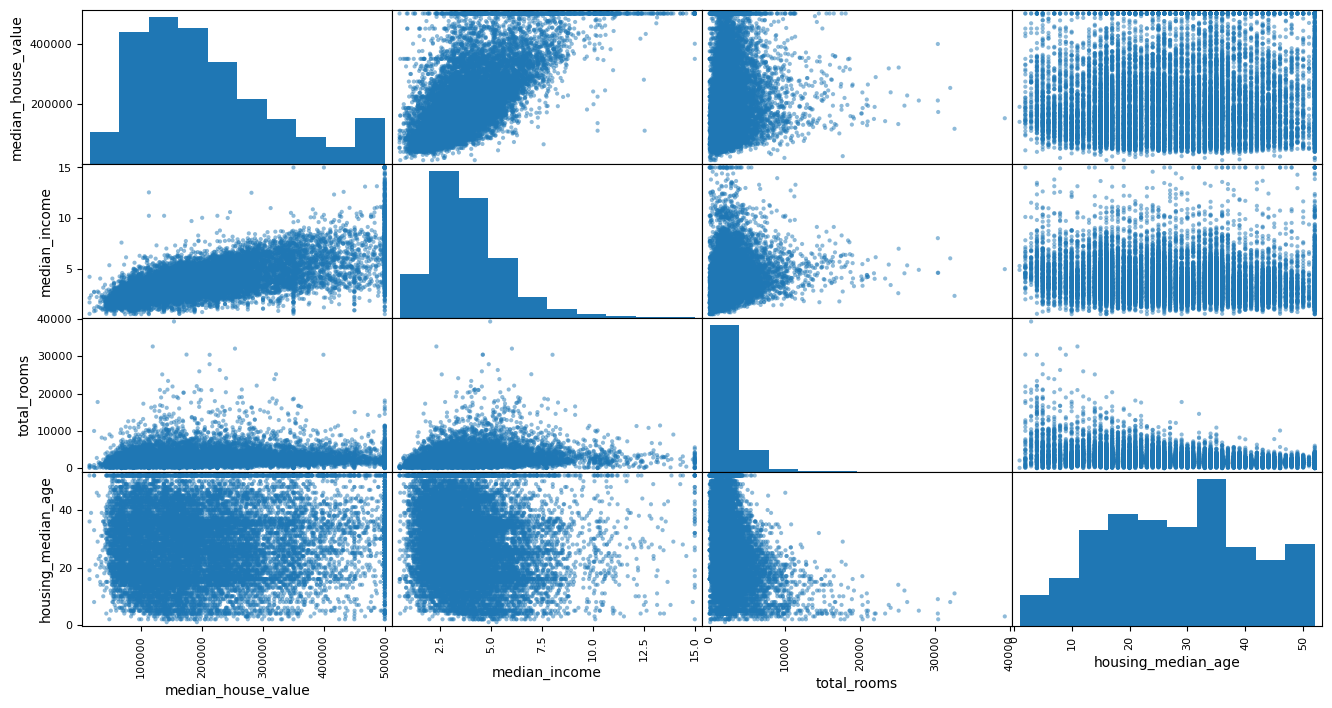

In [56]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"] # we select only a few attributes, aas otherwise we'll have to print 11*11=121 plots

scatter_matrix(housing2[attributes], figsize=(16, 8)) # the main diagonal displays a histogram for each attribute
plt.show()

^ The most promising attribute to predict median house value seems to be the median income, so let's zoom in on their scatterplot:

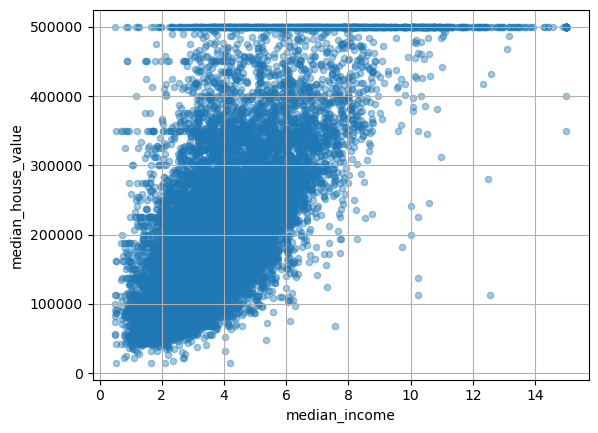

In [63]:
housing2.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.4, grid=True)
plt.show()

^ A few observations:
- the correlation is indeed quite strong: you can clearly see the upward trend, and the points are not too dispersed.

- the price cap is clearly visible as a horizontal line at $500,000. 

- there are 2 more, less obvious horizontal lines at $450,000 and $350,000. There may be even more such lines.

<b style="color: red; font-size: 1.2em;">!</b> The PCC only measures **linear** correlations:
<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/1920px-Correlation_examples2.svg.png" width="1000px">
    <figcaption>Source: Wikipedia</figcaption>
</figure>

One last thing to do now may be to try out various attribute combinations. For example, the total number of rooms in a distrcit is not very useful by itself, without the number of households taken into consideration:

In [68]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

housing2 = housing.copy()
housing2.pop("ocean_proximity")
corr_matrix = housing2.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688476
rooms_per_house       0.150164
total_rooms           0.128337
housing_median_age    0.106368
households            0.062350
total_bedrooms        0.046234
people_per_house     -0.020138
population           -0.028348
longitude            -0.046473
latitude             -0.145553
bedrooms_ratio       -0.249536
Name: median_house_value, dtype: float64

^ the new `bedrooms_ratio` attribute is much more correlated with the median house value that the total number of rooms or bedrooms. The number of rooms per household is also much more informative. 

## Time to prepare the data for ML Algorithms
We'll write functions for this so we don't need to write everything manually for each dataset we work with.

In [ ]:
# Separating features and labels:
housing = strat_trainset.drop("median_house_value", axis=1) # revert to the original dataset and drop the target column
housing_labels = strat_trainset["median_house_value"].copy()

### Cleaning the data:

#### Option 1: get rid of entries with missing data:
```python
housing.dropna(subset=["total_bedrooms"], inplace=True)
```

#### Option 2: get rid of the whole attribute:
```python
housing.drop("total_bedrooms", axis=1)
```

#### Option 3: set the missing values to something (zero, the mean, the median etc.) - this is called _imputation_
```python
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)
```
<br>

We'll use option #3, as it is the least destructive. Instead of the code above, however, we will use a handy Scikit-Learn class - `SimpleImputer`.

In [71]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = housing.select_dtypes(include=[np.number]) # the median can only be computed on numerical attributes

imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [74]:
X = imputer.transform(housing_num) # imputer outputs a NumpyArray (we called it X)
print(X) # X has no column names or an index for each entry

[[-118.13         34.06         17.         ...    3.01760563
     0.33372229    2.79929577]
 [-122.06         37.37         18.         ...    4.53037037
     0.21615435    2.04      ]
 [-117.9          34.11         23.         ...    4.02358888
     0.27554439    4.04128054]
 ...
 [-117.59         34.16         10.         ...    8.43761141
     0.12474913    3.40374332]
 [-119.79         36.77         30.         ...    4.05541562
     0.25465839    2.51889169]
 [-122.14         37.74         52.         ...    5.578125
     0.18767507    2.29166667]]


In [79]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index) # get a DataFrame
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedrooms_ratio,people_per_house
6753,-118.13,34.06,17.0,1714.0,572.0,1590.0,568.0,1.1875,183900.0,3.017606,0.333722,2.799296
11972,-122.06,37.37,18.0,3058.0,661.0,1377.0,675.0,6.1299,500001.0,4.530370,0.216154,2.040000
5439,-117.90,34.11,23.0,4776.0,1316.0,4797.0,1187.0,2.1667,142600.0,4.023589,0.275544,4.041281
6828,-121.83,38.00,15.0,6365.0,1646.0,3838.0,1458.0,2.5495,103600.0,4.365569,0.258602,2.632373
19055,-118.52,34.28,33.0,1975.0,271.0,801.0,287.0,7.8193,379600.0,6.881533,0.137215,2.790941


In [81]:
# don't forget about the non-numerical attributes:

housing_ctg = housing[["ocean_proximity"]]
housing_ctg.head(8)

,ocean_proximity
6753,<1H OCEAN
11972,<1H OCEAN
5439,<1H OCEAN
6828,INLAND
19055,<1H OCEAN
10495,INLAND
7440,INLAND
9500,INLAND


In [84]:
# ML Algorithms prefer numeric values, so let's encode the ocean_proximity attribute:

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_ctg_encoded = ordinal_encoder.fit_transform(housing_ctg)

print(housing_ctg_encoded[:8])

[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]


^ We mapped each category to a numerical value, but there is aa problem: the ML model will assume that two nearby values are more similar than to distant values. This is fine in some cases (e.g. when 0 = bad, 10 = good), but this is not our case. 

We will instead use one-hot encoding:

In [86]:
from sklearn.preprocessing import OneHotEncoder

ctg_encoder = OneHotEncoder()
housing_ctg_1hot = ctg_encoder.fit_transform(housing_ctg)

housing_ctg_1hot # this one is a SciPy sparse matrix

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>